In [1]:
# Import libraries
# type: ignore
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Imbalance datasets
from sklearn.utils.class_weight import compute_class_weight

# Model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Read data
def read_data(filename):
    X = pd.read_csv(f"../Data/process/X_{filename}_transformed.csv", header=0)
    y = pd.read_csv(f"../Data/process/y_{filename}.csv", header=0)['churn']
    return X, y

# Get model
def get_model(classifier):
    with open(f"../Model/{classifier}_search_model.pkl", 'rb+') as f:
        search_model, best_model = pickle.load(f)
        return search_model, best_model

In [3]:
# Datasets
X_train, y_train = read_data('train')          # Training data
X_valid, y_valid = read_data('Validation')     # Validation data
X_test, y_test = read_data('test')             # Test data

In [4]:
# Concate the training and validation data
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])

In [5]:
# Scoring function
def scoring_func(model, X, y): return roc_auc_score(y, model.predict_proba(X)[:, 1])

In [6]:
# Models
xgb_search_model, xgb_model = get_model('xgb')
knn_search_model, knn_model = get_model('knn')
log_search_model, log_model = get_model('log')
rf_search_model, rf_model = get_model('rf')

In [7]:
# Compute weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_dict = dict(zip(np.unique(y_train), class_weights))
weights_dict

{np.int64(0): np.float64(0.6280092108017584),
 np.int64(1): np.float64(2.4529844644317254)}

In [8]:
def model_training(search_model):

    # Best model
    best_model = search_model.best_estimator_
    best_model.fit(X, y)
    y_preds = best_model.predict_proba(X_test)[:, 1]  # make predictions on test data

    return best_model, y_preds


In [9]:
xgb_clf, xgb_y_preds = model_training(xgb_search_model)
knn_clf, knn_y_preds = model_training(knn_search_model)
log_clf, log_y_preds = model_training(log_search_model)
rf_clf, rf_y_preds = model_training(rf_search_model)

In [10]:
# Final predictions using ensemble
y_preds_proba = (xgb_y_preds + knn_y_preds + log_y_preds + rf_y_preds) / 4
y_preds = (y_preds_proba > 0.4).astype(int)

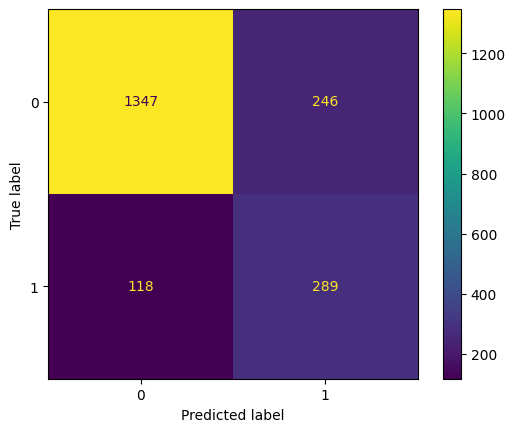

In [11]:
cm = confusion_matrix(y_test, y_preds)
ConfusionMatrixDisplay(cm).plot();

In [12]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_preds)
test_roc_auc = roc_auc_score(y_test, y_preds_proba)
test_precision, test_recall, test_f1score, support = precision_recall_fscore_support(y_test, y_preds, average='macro')

print(f"Accuracy ==> {accuracy: .2f}")
print(f"ROC-AUC score ==> {test_roc_auc:.2f}")
print(f"Precision score ==> {test_precision: .2f}")
print(f"Recall score ==> {test_recall: .2f}")
print(f"F1-score ==> {test_f1score: .2f}")

Accuracy ==>  0.82
ROC-AUC score ==> 0.86
Precision score ==>  0.73
Recall score ==>  0.78
F1-score ==>  0.75


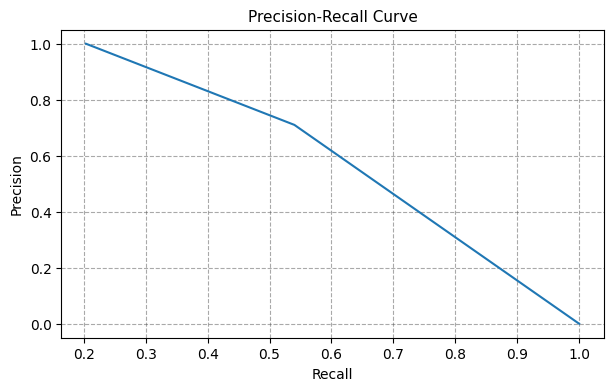

In [13]:
precision, recall, threshold = precision_recall_curve(y_test, y_preds)

plt.figure(figsize=(7, 4))
plt.plot(precision, recall)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve", size=11)

plt.grid(ls='--', color='#555', alpha=0.5)
plt.show()

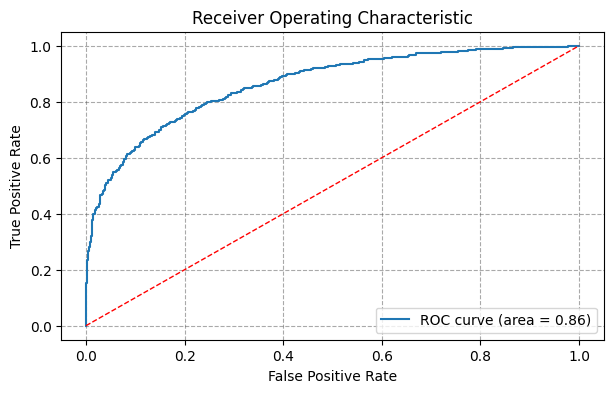

In [14]:
fpr, tpr, threshold = roc_curve(y_test, y_preds_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 4))

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

plt.legend(loc="lower right")
plt.grid(ls='--', color='#555', alpha=0.5)
plt.show()

- *Final ensemble model shows a good overall perfromance with 0.86 roc-score indicates the model has good measure of separability and is able to distinguish between positive and negative classes effectively.*
- *Model has relatively high recall and f1 score.*